In [88]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from collections import Counter
import operator
from wordcloud import WordCloud, STOPWORDS
import ast

In [51]:
!pip install wordcloud


    100% |████████████████████████████████| 368kB 2.9MB/s eta 0:00:01
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Load Data 

In [90]:
movies = pd.read_csv("/home/varuni/Desktop/Recsys/the-movies-dataset/movies_metadata.csv")
ratings = pd.read_csv("/home/varuni/Desktop/Recsys/the-movies-dataset/ratings.csv")
credits = pd.read_csv("/home/varuni/Desktop/Recsys/the-movies-dataset/credits.csv")

/home/varuni/anaconda3/envs/notroot/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Data Wrangling

In [45]:
movies.shape
movies = movies.drop(['imdb_id'],axis = 1)

In [46]:
movies['genres'] = movies['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies[movies['original_title'] != movies['title']][['title', 'original_title']].head()
movies = movies.drop('original_title', axis=1)
movies[movies['revenue'] == 0].shape
movies['revenue'] = movies['revenue'].replace(0, np.nan)
movies['budget'] = pd.to_numeric(movies['budget'], errors='coerce')
movies['budget'] = movies['budget'].replace(0, np.nan)
movies[movies['budget'].isnull()].shape
movies['return'] = movies['revenue'] / movies['budget']
movies[movies['return'].isnull()].shape
movies['year'] = pd.to_datetime(movies['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
movies['adult'].value_counts()
movies = movies.drop('adult', axis=1)
base_poster_url = 'http://image.tmdb.org/t/p/w185/'
movies['poster_path'] = "<img src='" + base_poster_url + movies['poster_path'] + "' style='height:100px;'>"

### Exploratory Data Analysis 

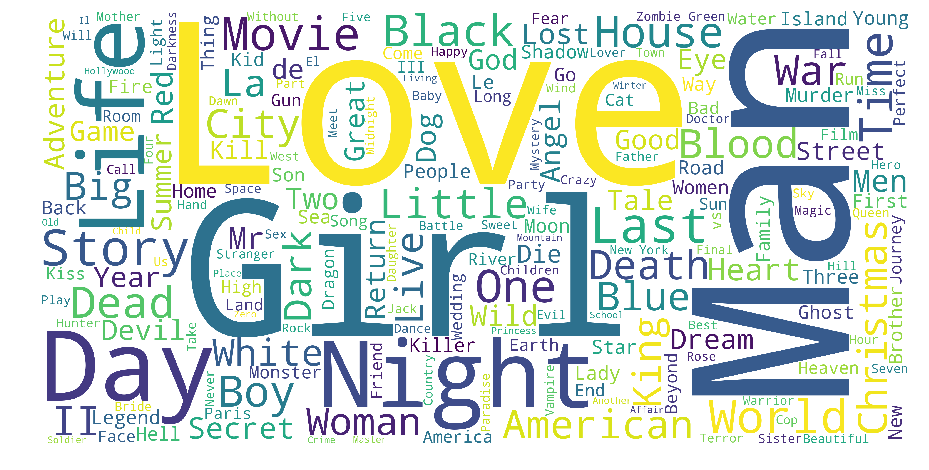

In [54]:
movies['title'] = movies['title'].astype('str')
movies['overview'] = movies['overview'].astype('str')
title_corpus = ' '.join(movies['title'])
overview_corpus = ' '.join(movies['overview'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

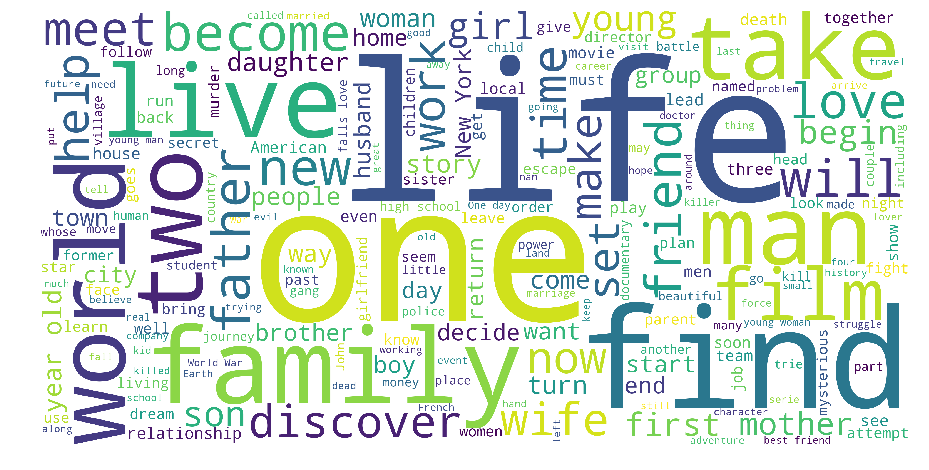

In [55]:
overview_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(overview_corpus)
plt.figure(figsize=(16,8))
plt.imshow(overview_wordcloud)
plt.axis('off')
plt.show()

In [32]:
genres = [item for sublist in movies['genres'] for item in sublist]
genres = dict(Counter(genres))
genres = dict(reversed(sorted(genres.items(),key=operator.itemgetter(1))))
topgenres = {k: genres[k] for k in list(genres)[:20]}

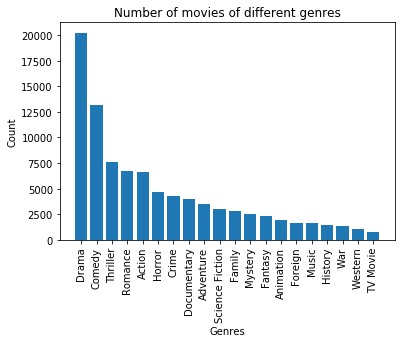

In [35]:

plt.bar(range(len(topgenres)), list(topgenres.values()), align='center')
plt.xticks(range(len(topgenres)), list(topgenres.keys()),rotation="vertical")
plt.xlabel("Genres")
plt.ylabel("Count")
plt.title("Number of movies of different genres")
plt.show()

In [57]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [58]:
movies['popularity'] = movies['popularity'].apply(clean_numeric).astype('float')
movies['vote_count'] = movies['vote_count'].apply(clean_numeric).astype('float')
movies['vote_average'] = movies['vote_average'].apply(clean_numeric).astype('float')

In [60]:
movies['popularity'].describe()

count    45460.000000
mean         2.921478
std          6.005414
min          0.000000
25%          0.385948
50%          1.127685
75%          3.678902
max        547.488298
Name: popularity, dtype: float64

/home/varuni/anaconda3/envs/notroot/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


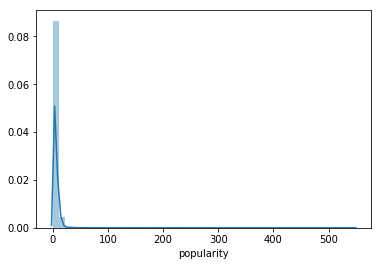

In [61]:
sns.distplot(movies['popularity'].fillna(movies['popularity'].median()))
plt.show()

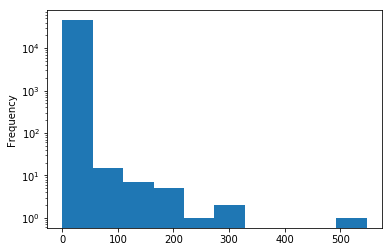

In [62]:
movies['popularity'].plot(logy=True, kind='hist')

In [63]:
movies[['title', 'popularity', 'year']].sort_values('popularity', ascending=False).head(10)

,title,popularity,year
30700,Minions,547.488298,2015
33356,Wonder Woman,294.337037,2017
42222,Beauty and the Beast,287.253654,2017
43644,Baby Driver,228.032744,2017
24455,Big Hero 6,213.849907,2014
26564,Deadpool,187.860492,2016
26566,Guardians of the Galaxy Vol. 2,185.330992,2017
14551,Avatar,185.070892,2009
24351,John Wick,183.870374,2014
23675,Gone Girl,154.801009,2014


In [65]:
movies['vote_count'].describe()

count    45460.000000
mean       109.897338
std        491.310374
min          0.000000
25%          3.000000
50%         10.000000
75%         34.000000
max      14075.000000
Name: vote_count, dtype: float64

In [66]:
movies[['title', 'vote_count', 'year']].sort_values('vote_count', ascending=False).head(10)

,title,vote_count,year
15480,Inception,14075.0,2010
12481,The Dark Knight,12269.0,2008
14551,Avatar,12114.0,2009
17818,The Avengers,12000.0,2012
26564,Deadpool,11444.0,2016
22879,Interstellar,11187.0,2014
20051,Django Unchained,10297.0,2012
23753,Guardians of the Galaxy,10014.0,2014
2843,Fight Club,9678.0,1999
18244,The Hunger Games,9634.0,2012


In [67]:
movies['vote_average'] = movies['vote_average'].replace(0, np.nan)
movies['vote_average'].describe()

count    42462.000000
mean         6.014877
std          1.256208
min          0.500000
25%          5.300000
50%          6.100000
75%          6.900000
max         10.000000
Name: vote_average, dtype: float64

/home/varuni/anaconda3/envs/notroot/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


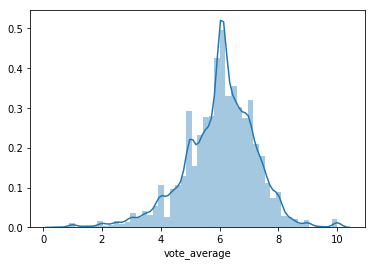

In [68]:
#Shows the distribution of the ratings 
sns.distplot(movies['vote_average'].fillna(movies['vote_average'].median()))

/home/varuni/anaconda3/envs/notroot/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


0.09664429948684439

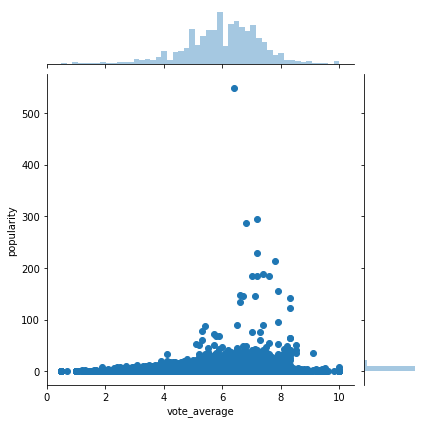

In [75]:
#This plot helps verify the relationship between popularity and vote average

sns.jointplot(x='vote_average', y='popularity', data=movies)
movies['vote_average'].corr(movies['popularity'])

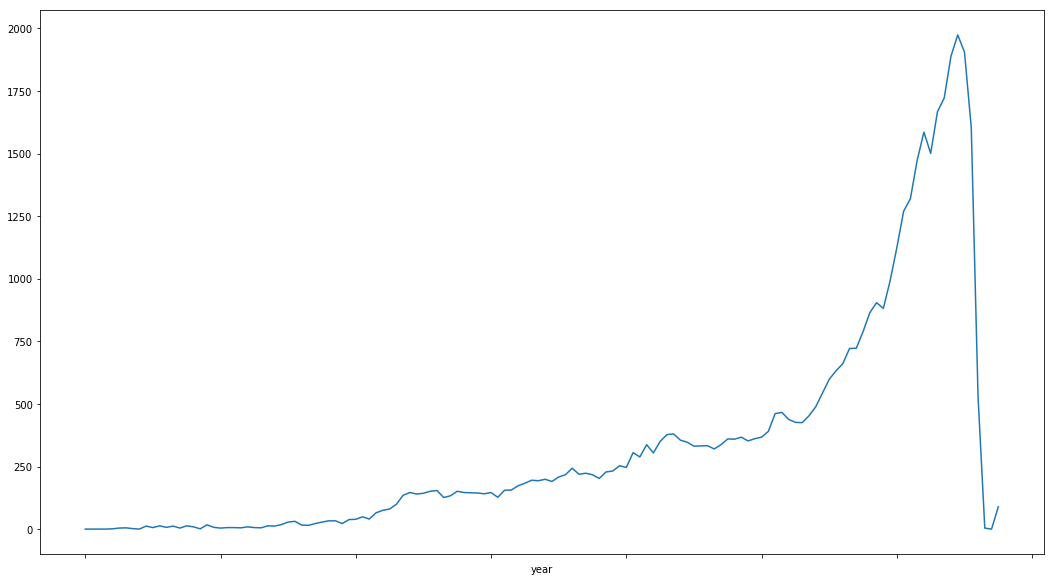

In [77]:
year_count = movies.groupby('year')['title'].count()
plt.figure(figsize=(18,10))
year_count.plot()

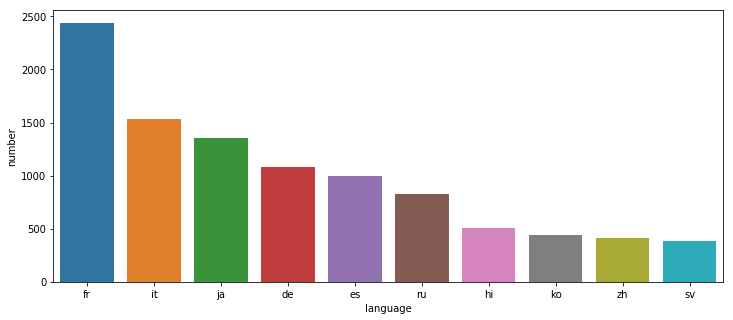

In [78]:
lang_df = pd.DataFrame(movies['original_language'].value_counts())
lang_df['language'] = lang_df.index
lang_df.columns = ['number', 'language']
plt.figure(figsize=(12,5))
sns.barplot(x='language', y='number', data=lang_df.iloc[1:11])
plt.show()

/home/varuni/anaconda3/envs/notroot/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


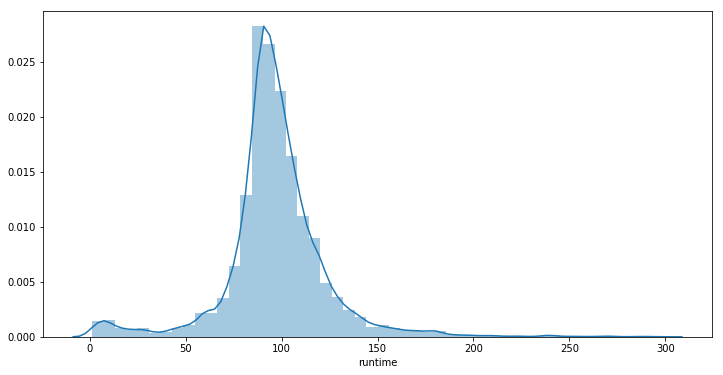

In [80]:
movies['runtime'] = movies['runtime'].astype('float')
plt.figure(figsize=(12,6))
sns.distplot(movies[(movies['runtime'] < 300) & (movies['runtime'] > 0)]['runtime'])

/home/varuni/anaconda3/envs/notroot/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


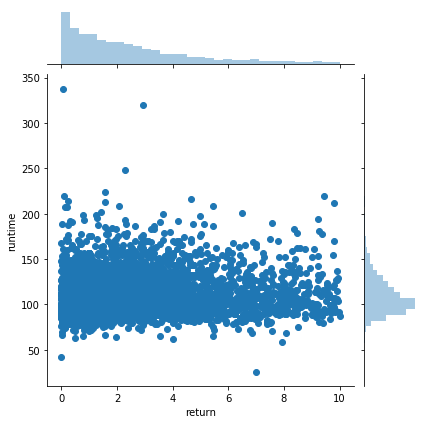

-0.0137343917439841

In [81]:
#The duration of a movie is independent of its success 
movies_mat = movies[(movies['return'].notnull()) & (movies['runtime'] > 0) & (movies['return'] < 10)]
sns.jointplot('return', 'runtime', data=movies_mat)
plt.show()
movies['return'].corr(movies['runtime'])

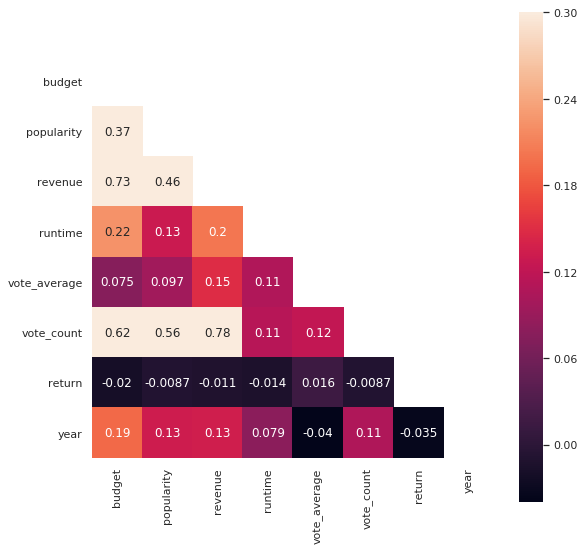

In [86]:
movies['year'] = movies['year'].replace('NaT', np.nan)
movies['year'] = movies['year'].apply(clean_numeric)
sns.set(font_scale=1)
corr = movies.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(9,9))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True)

In [92]:
movies['genres'] = movies['genres'].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
s = movies.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_movies = movies.drop('genres', axis=1).join(s)
gen_movies['genre'].value_counts().shape[0]
pop_gen = pd.DataFrame(gen_movies['genre'].value_counts()).reset_index()
pop_gen.columns = ['genre', 'movies']
pop_gen.head(10)


ValueError: malformed node or string: ['Animation', 'Comedy', 'Family']

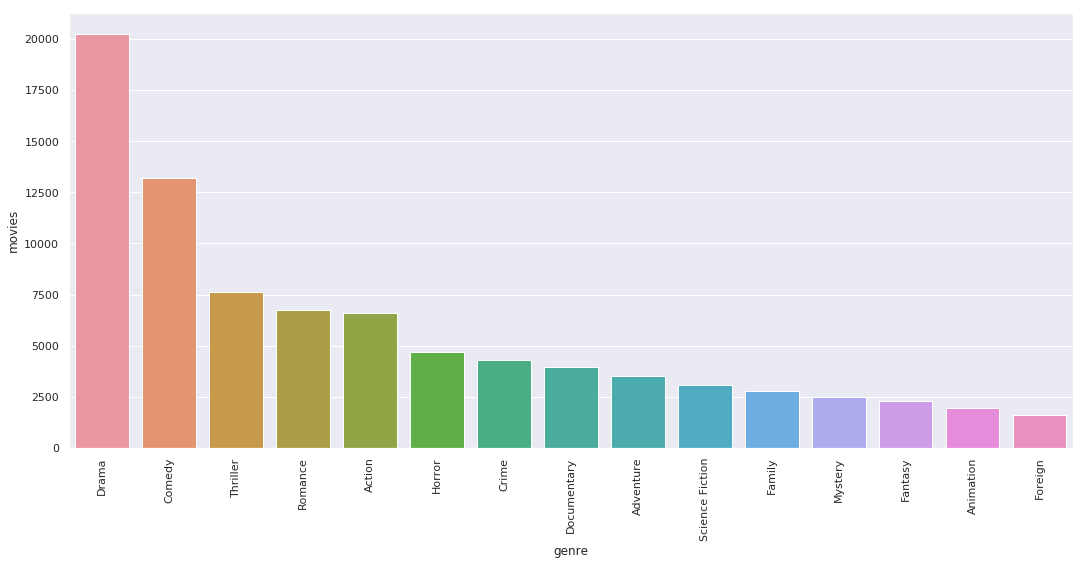

In [93]:
plt.figure(figsize=(18,8))
sns.barplot(x='genre', y='movies', data=pop_gen.head(15))
plt.xticks(rotation = "vertical")
plt.show()

### Cast and crew data

In [ ]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan
df['id'] = df['id'].apply(convert_int)
df = df.drop(df[df['id'].isnull()])
